In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

### Dataset

In [32]:
filepath = '/home/hugo/projetos-doutorado/Appliance-Energy-Prediction/data/energydata_complete.csv'
df = pd.read_csv(filepath, parse_dates=['date'], index_col='date')
print(df.shape)  # (123, 8)
df = df.drop(labels=['rv1','rv2'], axis=1)
df.tail()

(19735, 28)


,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint
date,,,,,,,,,,,,,,,,,,,,,
2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.7,45.590000,...,24.7000,50.07400,23.2,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333
2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.7,45.590000,...,24.7000,49.79000,23.2,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000
2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.7,45.730000,...,24.7000,49.66000,23.2,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667
2016-05-27 17:50:00,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.7,45.790000,...,24.6625,49.51875,23.2,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333
2016-05-27 18:00:00,430,10,25.500000,46.600000,25.264286,42.971429,26.823333,41.156667,24.7,45.963333,...,24.7360,49.73600,23.2,46.8450,22.200000,755.2,57.000000,4.000000,27.000000,13.200000


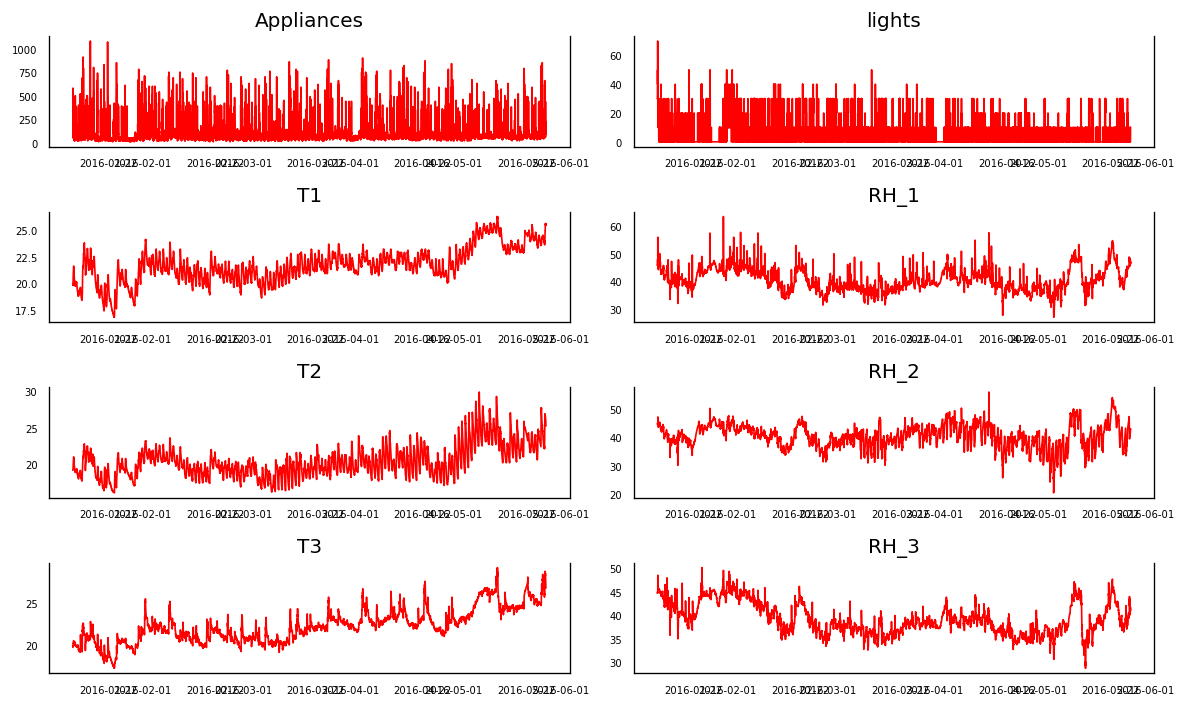

In [33]:
# Plot
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

### Testing Causation using Granger’s Causality Test

In [34]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_matrix = grangers_causation_matrix(df, variables = df.columns)     

/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1836: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '


In [35]:
grangers_matrix

,Appliances_x,lights_x,T1_x,RH_1_x,T2_x,RH_2_x,T3_x,RH_3_x,T4_x,RH_4_x,...,T8_x,RH_8_x,T9_x,RH_9_x,T_out_x,Press_mm_hg_x,RH_out_x,Windspeed_x,Visibility_x,Tdewpoint_x
Appliances_y,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0131,0.2493,...,0.0000,0.0000,0.4007,0.0000,0.0000,0.0002,0.0000,0.0000,0.3620,0.0009
lights_y,0.0000,1.0000,0.0000,0.0000,0.0391,0.0131,0.0000,0.0000,0.0011,0.0000,...,0.0001,0.0001,0.0000,0.0000,0.0012,0.0000,0.0084,0.0009,0.4103,0.0152
T1_y,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.3702,0.0000,0.0000,0.0002,0.0000
RH_1_y,0.0000,0.0000,0.0000,1.0000,0.0006,0.0000,0.0000,0.0000,0.4874,0.0000,...,0.0001,0.0000,0.1525,0.0000,0.0000,0.0000,0.0000,0.0063,0.5516,0.0000
T2_y,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0001,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0004,0.0000,0.0005,0.0805,0.0000
RH_2_y,0.0000,0.0009,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1010,0.0000
T3_y,0.0000,0.0097,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0067,...,0.0000,0.0291,0.0000,0.1739,0.0000,0.3091,0.0000,0.0001,0.8262,0.0000
RH_3_y,0.0000,0.0000,0.0000,0.0000,0.0278,0.0000,0.0000,1.0000,0.3216,0.0000,...,0.1256,0.0000,0.0912,0.0000,0.0003,0.0778,0.0000,0.0142,0.5593,0.0000
T4_y,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.6805,1.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0015,0.1048,0.0000
RH_4_y,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0906,0.0000,0.0000,1.0000,...,0.1078,0.0000,0.0095,0.0000,0.0000,0.0026,0.0000,0.0023,0.1113,0.0000


<AxesSubplot:>

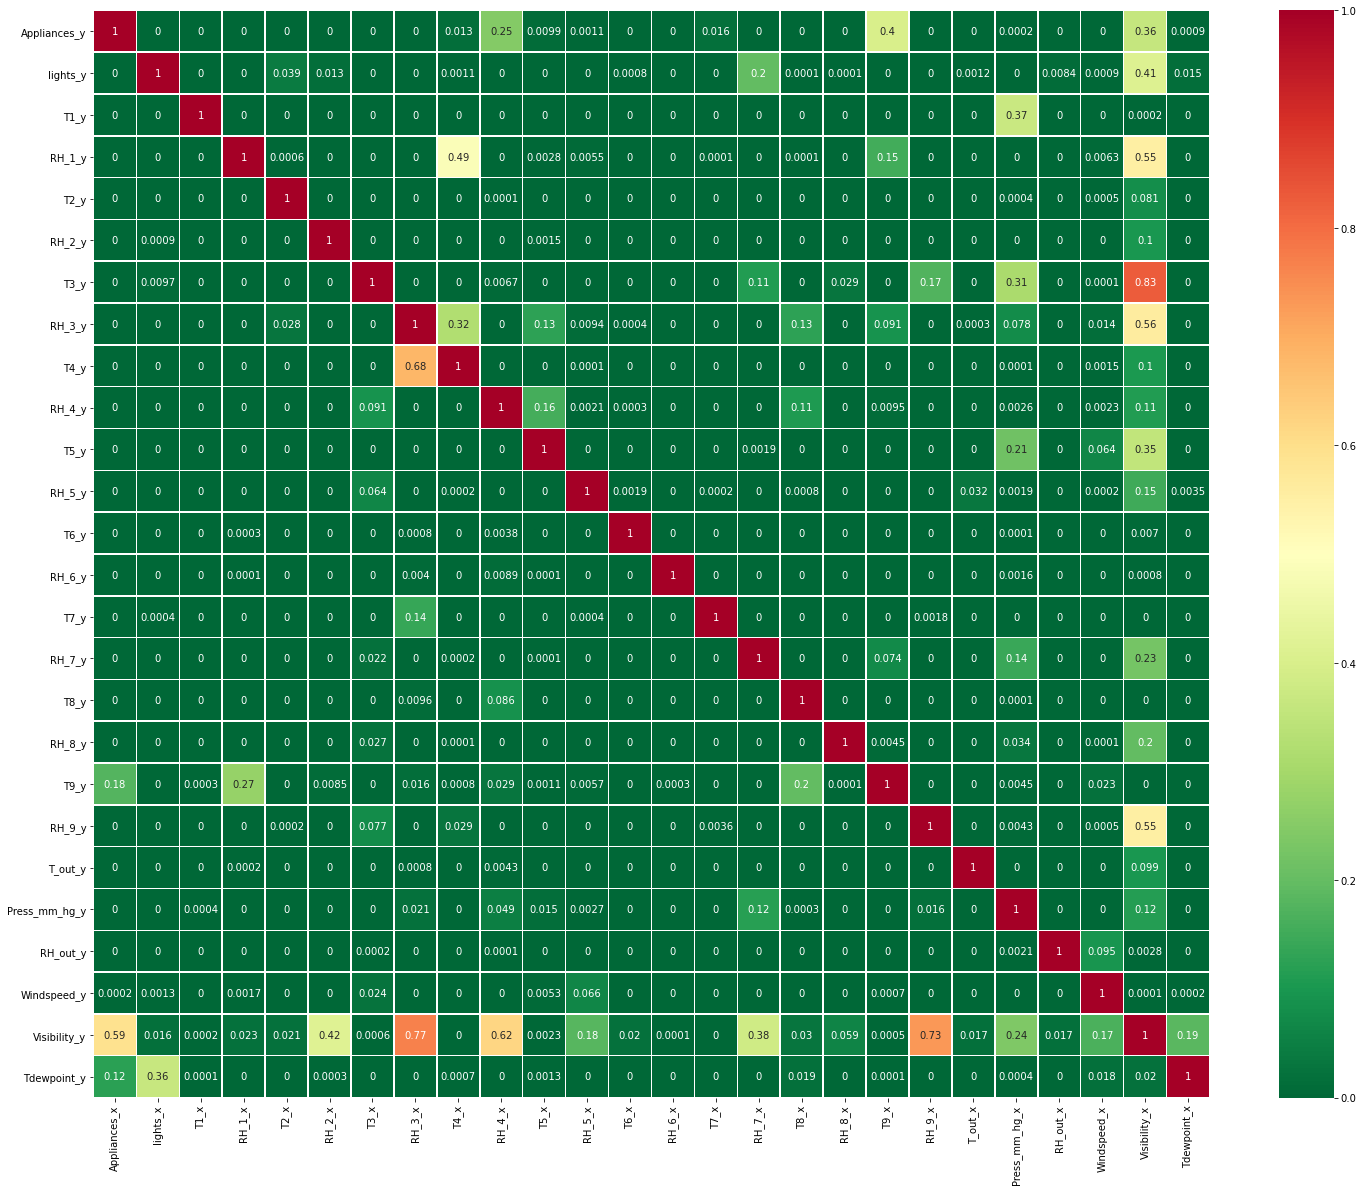

In [36]:
f, ax = plt.subplots(figsize=(25, 20))
sns.heatmap(grangers_matrix, cmap='RdYlGn_r', annot=True,linewidths=.5)

### Cointegration Test

<AxesSubplot:>

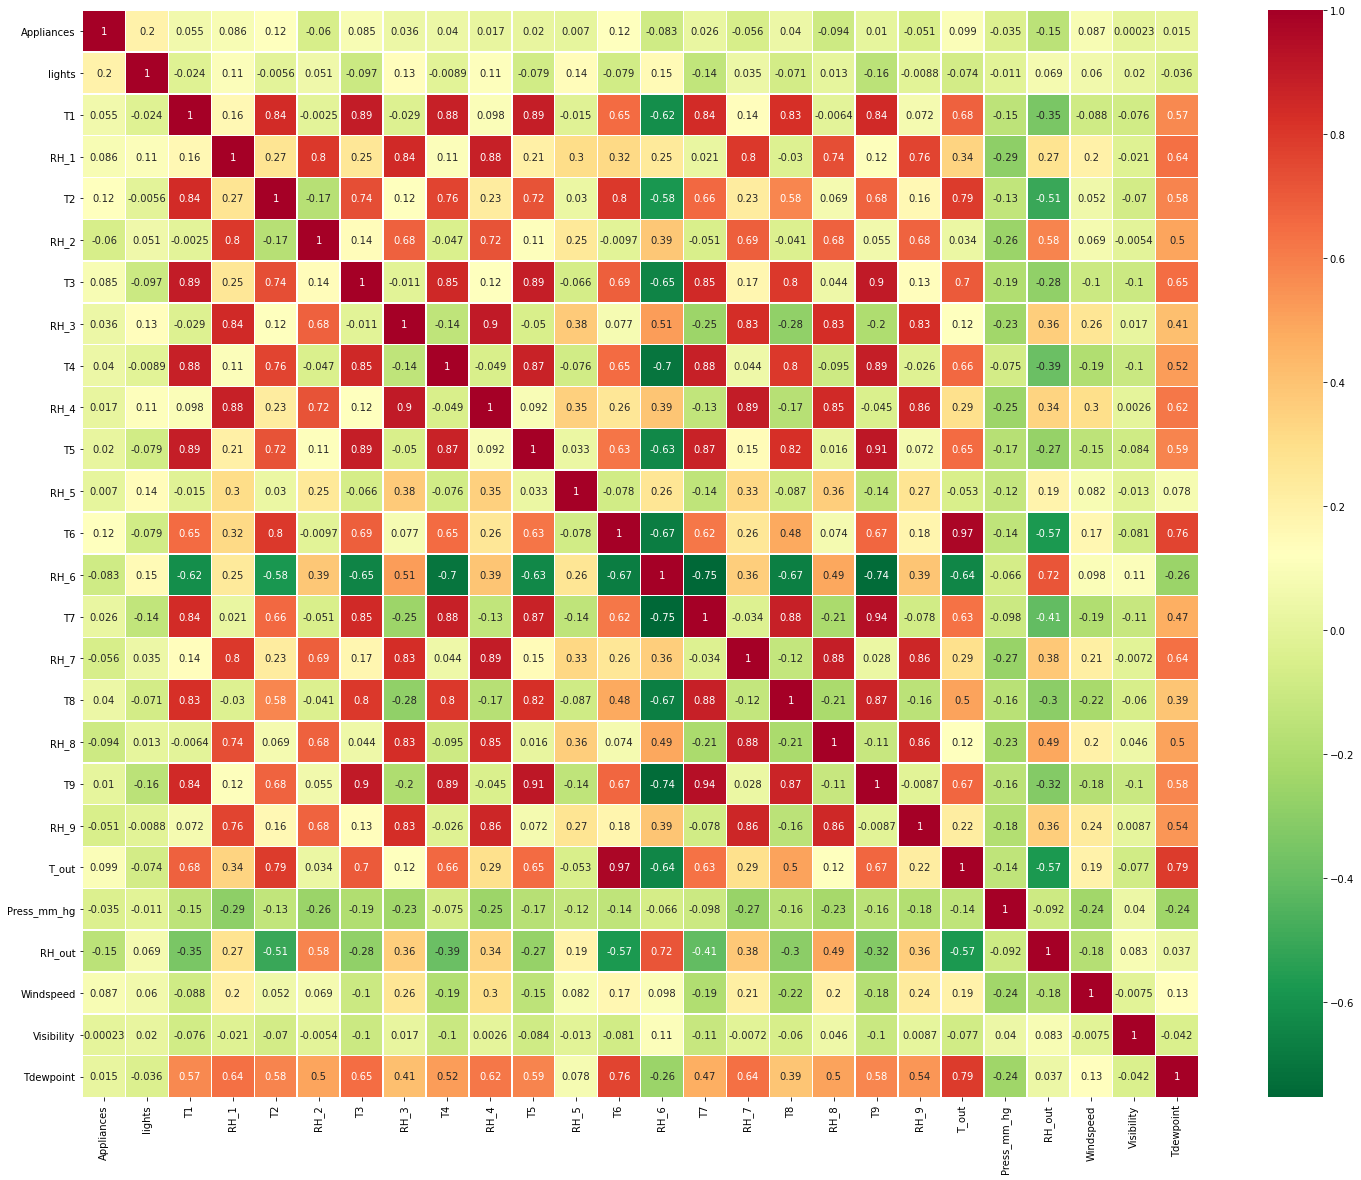

In [37]:
cov_data= df.corr()
f, ax = plt.subplots(figsize=(25, 20))
sns.heatmap(cov_data, cmap='RdYlGn_r', annot=True,linewidths=.5)

In [38]:
cov_data= df.corr()
cov_data

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint
Appliances,1.000000,0.197278,0.055447,0.086031,0.120073,-0.060465,0.085060,0.036292,0.040281,0.016965,...,0.039572,-0.094039,0.010010,-0.051462,0.099155,-0.034885,-0.152282,0.087122,0.000230,0.015353
lights,0.197278,1.000000,-0.023528,0.106968,-0.005622,0.050985,-0.097393,0.131161,-0.008859,0.114936,...,-0.071458,0.012915,-0.157592,-0.008766,-0.074424,-0.010576,0.068543,0.060281,0.020038,-0.036322
T1,0.055447,-0.023528,1.000000,0.164006,0.836834,-0.002509,0.892402,-0.028550,0.877001,0.097861,...,0.825413,-0.006441,0.844777,0.071756,0.682846,-0.150574,-0.345481,-0.087654,-0.076210,0.571309
RH_1,0.086031,0.106968,0.164006,1.000000,0.269839,0.797535,0.253230,0.844677,0.106180,0.880359,...,-0.030053,0.736196,0.115263,0.764001,0.340767,-0.293957,0.274126,0.204932,-0.021057,0.639106
T2,0.120073,-0.005622,0.836834,0.269839,1.000000,-0.165610,0.735245,0.121497,0.762066,0.231563,...,0.578191,0.068534,0.675535,0.157346,0.792255,-0.133028,-0.505291,0.052495,-0.069721,0.582602
RH_2,-0.060465,0.050985,-0.002509,0.797535,-0.165610,1.000000,0.137319,0.678326,-0.047304,0.721435,...,-0.041023,0.679777,0.054544,0.676467,0.033674,-0.255646,0.584911,0.069190,-0.005368,0.499152
T3,0.085060,-0.097393,0.892402,0.253230,0.735245,0.137319,1.000000,-0.011234,0.852778,0.122737,...,0.795283,0.044427,0.901324,0.134602,0.699417,-0.189974,-0.281718,-0.100776,-0.102310,0.645886
RH_3,0.036292,0.131161,-0.028550,0.844677,0.121497,0.678326,-0.011234,1.000000,-0.140457,0.898978,...,-0.283228,0.828822,-0.195270,0.833538,0.118207,-0.233274,0.356192,0.263188,0.017041,0.414387
T4,0.040281,-0.008859,0.877001,0.106180,0.762066,-0.047304,0.852778,-0.140457,1.000000,-0.048650,...,0.796256,-0.095192,0.889439,-0.025549,0.663478,-0.075292,-0.388602,-0.185747,-0.104768,0.519471
RH_4,0.016965,0.114936,0.097861,0.880359,0.231563,0.721435,0.122737,0.898978,-0.048650,1.000000,...,-0.167066,0.847259,-0.044518,0.856591,0.293289,-0.250748,0.336813,0.300192,0.002636,0.616509


In [48]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/vector_ar/vecm.py:577: HypothesisTestWarning: Critical values are only available for time series with 12 variables at most.
  warnings.warn("Critical values are only available for time series "


Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Appliances ::  11849.96  > nan       =>   False
lights ::  9643.94   > nan       =>   False
T1     ::  8245.57   > nan       =>   False
RH_1   ::  7102.93   > nan       =>   False
T2     ::  6076.93   > nan       =>   False
RH_2   ::  5206.19   > nan       =>   False
T3     ::  4496.06   > nan       =>   False
RH_3   ::  3908.28   > nan       =>   False
T4     ::  3367.16   > nan       =>   False
RH_4   ::  2880.24   > nan       =>   False
T5     ::  2451.58   > nan       =>   False
RH_5   ::  2075.91   > nan       =>   False
T6     ::  1751.68   > nan       =>   False
RH_6   ::  1472.46   > nan       =>   False
T7     ::  1245.95   > 311.1288  =>   True
RH_7   ::  1025.63   > 263.2603  =>   True
T8     ::  831.27    > 219.4051  =>   True
RH_8   ::  653.9     > 179.5199  =>   True
T9     ::  515.01    > 143.6691  =>   True
RH_9   ::  390.79    > 111.7797  =>   True
T_out  ::  273.3     > 83.9383   

In [40]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  

In [41]:
# ADF Test on each column
for name, column in df.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Appliances" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -21.6164
 No. Lags Chosen       = 11
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "lights" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -21.5759
 No. Lags Chosen       = 15
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "T1" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level 

    Augmented Dickey-Fuller Test on "T_out" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.3767
 No. Lags Chosen       = 45
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Press_mm_hg" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.7173
 No. Lags Chosen       = 43
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "RH_out" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Leve

In [42]:
df_differenced = df.diff().dropna()
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Appliances" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -29.8659
 No. Lags Chosen       = 42
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "lights" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -29.9861
 No. Lags Chosen       = 45
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "T1" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level 

    Augmented Dickey-Fuller Test on "T_out" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -22.5735
 No. Lags Chosen       = 45
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Press_mm_hg" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -12.505
 No. Lags Chosen       = 42
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "RH_out" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Lev

### KPSS test

In [43]:
# regression='ct'
# KPSS test
from statsmodels.tsa.stattools import kpss
def kpss_test(series, name='', **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Test on "{name}"', "\n   ", '-'*47)
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')


In [44]:
for name, column in df.iteritems():
    kpss_test(column, name=column.name)
    print('\n')

KPSS Test on "Appliances" 
    -----------------------------------------------
KPSS Statistic: 0.03892801361687985
p-value: 0.1
num lags: 45
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


KPSS Test on "lights" 
    -----------------------------------------------
KPSS Statistic: 4.728576720208184
p-value: 0.01
num lags: 45
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


KPSS Test on "T1" 
    -----------------------------------------------
KPSS Statistic: 21.87581707300442
p-value: 0.01
num lags: 45
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


KPSS Test on "RH_1" 
    -----------------------------------------------
KPSS Statistic: 2.877921129856753
p-value: 0.01
num lags: 45
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


KPSS 

/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2041: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2076: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2072: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  war

In [45]:
df_differenced = df.diff().dropna()
for name, column in df_differenced.iteritems():
    kpss_test(column, name=column.name)
    print('\n')

/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2041: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2076: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2076: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  war

KPSS Test on "Appliances" 
    -----------------------------------------------
KPSS Statistic: 0.004728250272411956
p-value: 0.1
num lags: 45
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


KPSS Test on "lights" 
    -----------------------------------------------
KPSS Statistic: 0.006424252966743214
p-value: 0.1
num lags: 45
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


KPSS Test on "T1" 
    -----------------------------------------------
KPSS Statistic: 0.006224805825555264
p-value: 0.1
num lags: 45
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


KPSS Test on "RH_1" 
    -----------------------------------------------
KPSS Statistic: 0.02523338260326237
p-value: 0.1
num lags: 45
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


KPSS Test o

/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2076: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2076: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2076: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2076: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The

### How to Select the Order (P) of VAR model

In [47]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -90.54855581320692
BIC :  -90.26786795817225
FPE :  4.734366614512718e-40
HQIC:  -90.45666372059412 



/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


Lag Order = 2
AIC :  -91.42301944648885
BIC :  -90.87201519886452
FPE :  1.974637049705538e-40
HQIC:  -91.2426302462617 

Lag Order = 3
AIC :  -91.73912427829066
BIC :  -90.91777971069828
FPE :  1.439478008858676e-40
HQIC:  -91.47022970237467 

Lag Order = 4
AIC :  -91.98256555249752
BIC :  -90.89085673418452
FPE :  1.1284452268824464e-40
HQIC:  -91.62515733161979 

Lag Order = 5
AIC :  -92.17414846134011
BIC :  -90.81205145817908
FPE :  9.31704413879265e-41
HQIC:  -91.72821832502916 

Lag Order = 6
AIC :  -92.39882142362437
BIC :  -90.76631229811242
FPE :  7.442271607638727e-41
HQIC:  -91.86436110020982 

Lag Order = 7
AIC :  -93.68113685477809
BIC :  -91.7781916660362
FPE :  2.0644540234279319e-41
HQIC:  -93.05813807139049 

Lag Order = 8
AIC :  -93.72726078533651
BIC :  -91.55385558910886
FPE :  1.9714092548240662e-41
HQIC:  -93.01571526790707 

Lag Order = 9
AIC :  -93.7656614953308
BIC :  -91.32177234398414
FPE :  1.8971573441583194e-41
HQIC:  -92.96556096859118 



In [49]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,-75.48,-75.47,1.661e-33,-75.47
1,-90.56,-90.28,4.696e-40,-90.46
2,-91.43,-90.88,1.958e-40,-91.25
3,-91.75,-90.93,1.426e-40,-91.48
4,-91.99,-90.90,1.117e-40,-91.63
5,-92.18,-90.82,9.218e-41,-91.74
6,-92.41,-90.78,7.358e-41,-91.88
7,-93.69,-91.79*,2.041e-41,-93.07*
8,-93.74,-91.57,1.948e-41,-93.03
9,-93.78,-91.33,1.873e-41,-92.98
